The code was adapted from: https://www.pymc.io/projects/examples/en/latest/case_studies/BART_introduction.html

In [10]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
# import pymc_bart as pmb
import bart_rs as pmb

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


In [11]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Coal mining example

In [12]:
try:
    coal = np.loadtxt(Path("..", "data", "coal.csv"))
except FileNotFoundError:
    coal = np.loadtxt(pm.get_data("coal.csv"))

In [13]:
# discretize data
years = int(coal.max() - coal.min())
bins = years // 4
hist, x_edges = np.histogram(coal, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4

In [16]:
with pm.Model() as model_coal:
    μ_ = pmb.BART("μ_", X=x_data, Y=y_data, m=50)
    μ = pm.Deterministic("μ", np.abs(μ_))
    y_pred = pm.Poisson("y_pred", mu=μ, observed=y_data)
    idata_coal = pm.sample(random_seed=RANDOM_SEED)

/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/

/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/

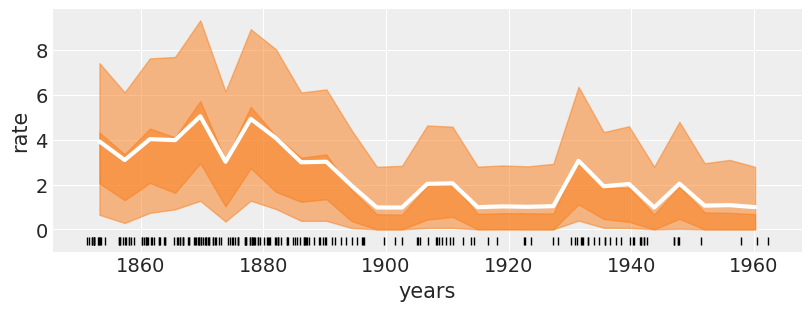

In [17]:
_, ax = plt.subplots(figsize=(8, 3))

rates = idata_coal.posterior["μ"]
rate_mean = idata_coal.posterior["μ"].mean(dim=["draw", "chain"])
ax.plot(x_centers, rate_mean, "w", lw=3)
az.plot_hdi(x_centers, rates, smooth=False)
az.plot_hdi(x_centers, rates, hdi_prob=0.5, smooth=False, plot_kwargs={"alpha": 0})
ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate");

## Bike sharing example

In [18]:
try:
    bikes = pd.read_csv(Path("..", "data", "bikes.csv"))
except FileNotFoundError:
    bikes = pd.read_csv(pm.get_data("bikes.csv"))

X = bikes[["hour", "temperature", "humidity", "workingday"]]
Y = bikes["count"]

In [22]:
X.shape

(348, 4)

In [21]:
with pm.Model() as model_bikes:
    σ = pm.HalfNormal("σ", Y.std())
    μ = pmb.BART("μ", X, Y, m=50)
    y = pm.Normal("y", μ, σ, observed=Y)
    idata_bikes = pm.sample(random_seed=RANDOM_SEED)

/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/

/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/